In [10]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sympy import symbols, simplify, lambdify, Float, exp, Eq, solve
from scipy.interpolate import lagrange as scipy_lagrange

In [11]:
def interpolacao_lagrange(x_vals, y_vals):
    x = symbols('x')
    n = len(x_vals)
    L = 0
    for i in range(n):
        termo = 1
        for j in range(n):
            if i != j:
                termo *= (x - x_vals[j]) / (x_vals[i] - x_vals[j])
        L += y_vals[i] * termo

    L = sp.simplify(L)
    L = sp.expand(L)
    coeffs = sp.Poly(L).all_coeffs()
    rounded_coeffs = [Float(c.evalf(), 4) for c in coeffs]
    L = sum(c * x**i for i, c in enumerate(reversed(rounded_coeffs)))

    f_lagrange = lambdify(x, L, 'numpy')
    tabela = [(round(xi, 4), round(f_lagrange(xi), 4)) for xi in x_vals]

    return L, tabela, f_lagrange

In [12]:
def interpolar_inverso(L, y_desejado):
    x = symbols('x')
    eq = Eq(L, y_desejado)
    sol = solve(eq, x)
    sol_reais = [s.evalf() for s in sol if s.is_real]
    return sol_reais

Interpolação de Lagrange

Polinômio interpolador de Lagrange:
           2                   
- 0.01905⋅x  + 2.838⋅x + 1449.0

Tabela de pontos interpolados:
x = 86.0000, y = 1552.1742
x = 93.0000, y = 1548.1706
x = 98.0000, y = 1544.1678
Para x = 100.0000, y estimado = 1542.3000


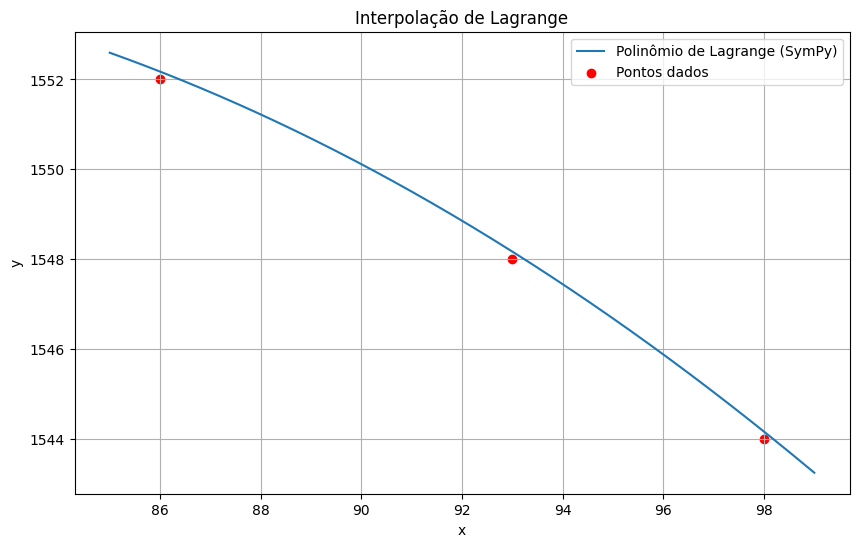

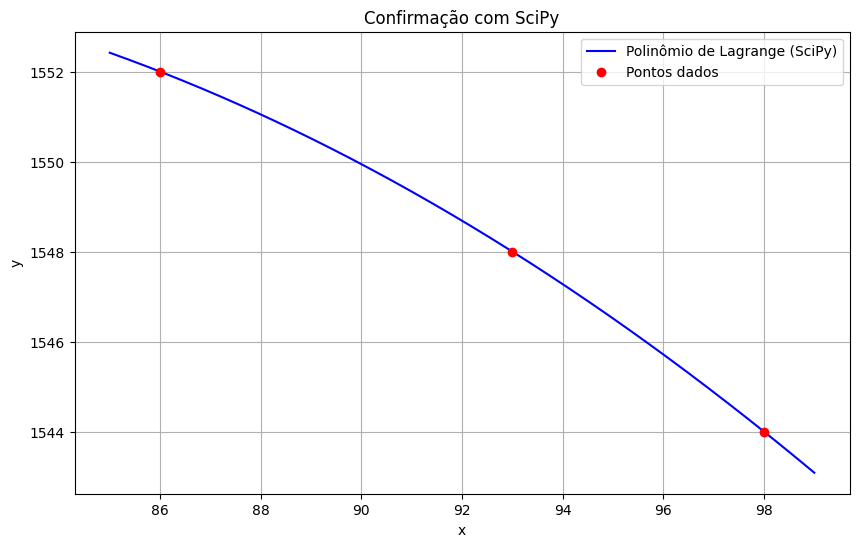

In [19]:
# === INÍCIO DO SCRIPT PRINCIPAL ===
print("Interpolação de Lagrange")

modo = input("Você deseja fornecer os valores de y manualmente (1) ou usar uma função f(x) para calcular (2)? ")

n = int(input("Digite o número de pontos (n): "))
x_vals = []
y_vals = []

for i in range(n):
    x = float(input(f"x{i}: "))
    x_vals.append(x)

if modo == '1':
    for i in range(n):
        y = float(input(f"y{i} correspondente a x{i} = {x_vals[i]}: "))
        y_vals.append(y)
elif modo == '2':
    f_expr = input("Digite a função f(x), exemplo: 2*exp(x) + 3: ")
    x = sp.symbols('x')
    try:
        f_sympy = sp.sympify(f_expr)
        f_numeric = sp.lambdify(x, f_sympy, 'numpy')
        for xi in x_vals:
            yi = float(f_numeric(xi))
            y_vals.append(yi)
    except Exception as e:
        print("Erro ao processar a função:", e)
        exit(1)
else:
    print("Modo inválido. Use 1 ou 2.")
    exit(1)

L, tabela, f_lagrange = interpolacao_lagrange(x_vals, y_vals)

print("\nPolinômio interpolador de Lagrange:")
print(sp.pretty(L, use_unicode=True))

print("\nTabela de pontos interpolados:")
for xi, yi in tabela:
    print(f"x = {xi:.4f}, y = {yi:.4f}")

# Loop de interação com o usuário
while True:
    escolha = input("\nDeseja (1) estimar y dado x ou (2) estimar x dado y? ('sair' para encerrar): ")
    if escolha.lower() == 'sair':
        break
    elif escolha == '1':
        try:
            x_input = float(input("Digite um valor de x: "))
            y_estimado = f_lagrange(x_input)
            print(f"Para x = {x_input:.4f}, y estimado = {y_estimado:.4f}")
        except:
            print("Erro ao processar entrada.")
    elif escolha == '2':
        try:
            y_input = float(input("Digite um valor de y: "))
            x_estimado = interpolar_inverso(L, y_input)
            if x_estimado:
                print("Possíveis valores de x para y = {:.4f}:".format(y_input))
                for x_sol in x_estimado:
                    print(f"x ≈ {x_sol:.4f}")
            else:
                print("Nenhuma solução real encontrada.")
        except:
            print("Erro ao processar entrada.")
    else:
        print("Escolha inválida. Use 1, 2 ou 'sair'.")

# Gráfico SymPy
x_plot = np.linspace(min(x_vals) - 1, max(x_vals) + 1, 500)
y_plot = f_lagrange(x_plot)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, y_plot, label='Polinômio de Lagrange (SymPy)')
plt.scatter(x_vals, y_vals, color='red', label='Pontos dados')
plt.title('Interpolação de Lagrange')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# Comparação com scipy
f_scipy = scipy_lagrange(np.array(x_vals), np.array(y_vals))
x_new = np.linspace(min(x_vals) - 1, max(x_vals) + 1, 500)

plt.figure(figsize=(10, 6))
plt.plot(x_new, f_scipy(x_new), 'b', label='Polinômio de Lagrange (SciPy)')
plt.plot(x_vals, y_vals, 'ro', label='Pontos dados')
plt.title('Confirmação com SciPy')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()